## Terminator

Procederé a aplicar todo lo que no aprendí este semestre según mis calificaciones 

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
from sklearn import preprocessing as ps
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
d2=pd.read_csv("Data_set_200_280.csv")

In [ ]:
d2

Inicialmente se hace un encoder para convertir las variables cualitativas en cuantitativas en este caso solo afectando la columna de estados

In [62]:
encoder = ps.LabelEncoder()
d2["Estado"]=encoder.fit_transform(d2["Estado"])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Estado     4919 non-null   int32  
 1   Sumatoria  4919 non-null   float64
 2   Mediana    4919 non-null   float64
 3   Varianza   4919 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 134.6 KB
None


In [ ]:
d2

En este caso Sano:1 crepitante:0 y silibante:2

Normalizaremos los valores de cada columna dividiéndolos por el valor máximo para tener valores entre 0 y 1 en cada columna

In [9]:
for i in d2.columns.values[1:]:
    d2[i]=d2[i]/np.max(d2[i])

Ahora revisemos la correlación con nuestro target de predicción que seria el estado

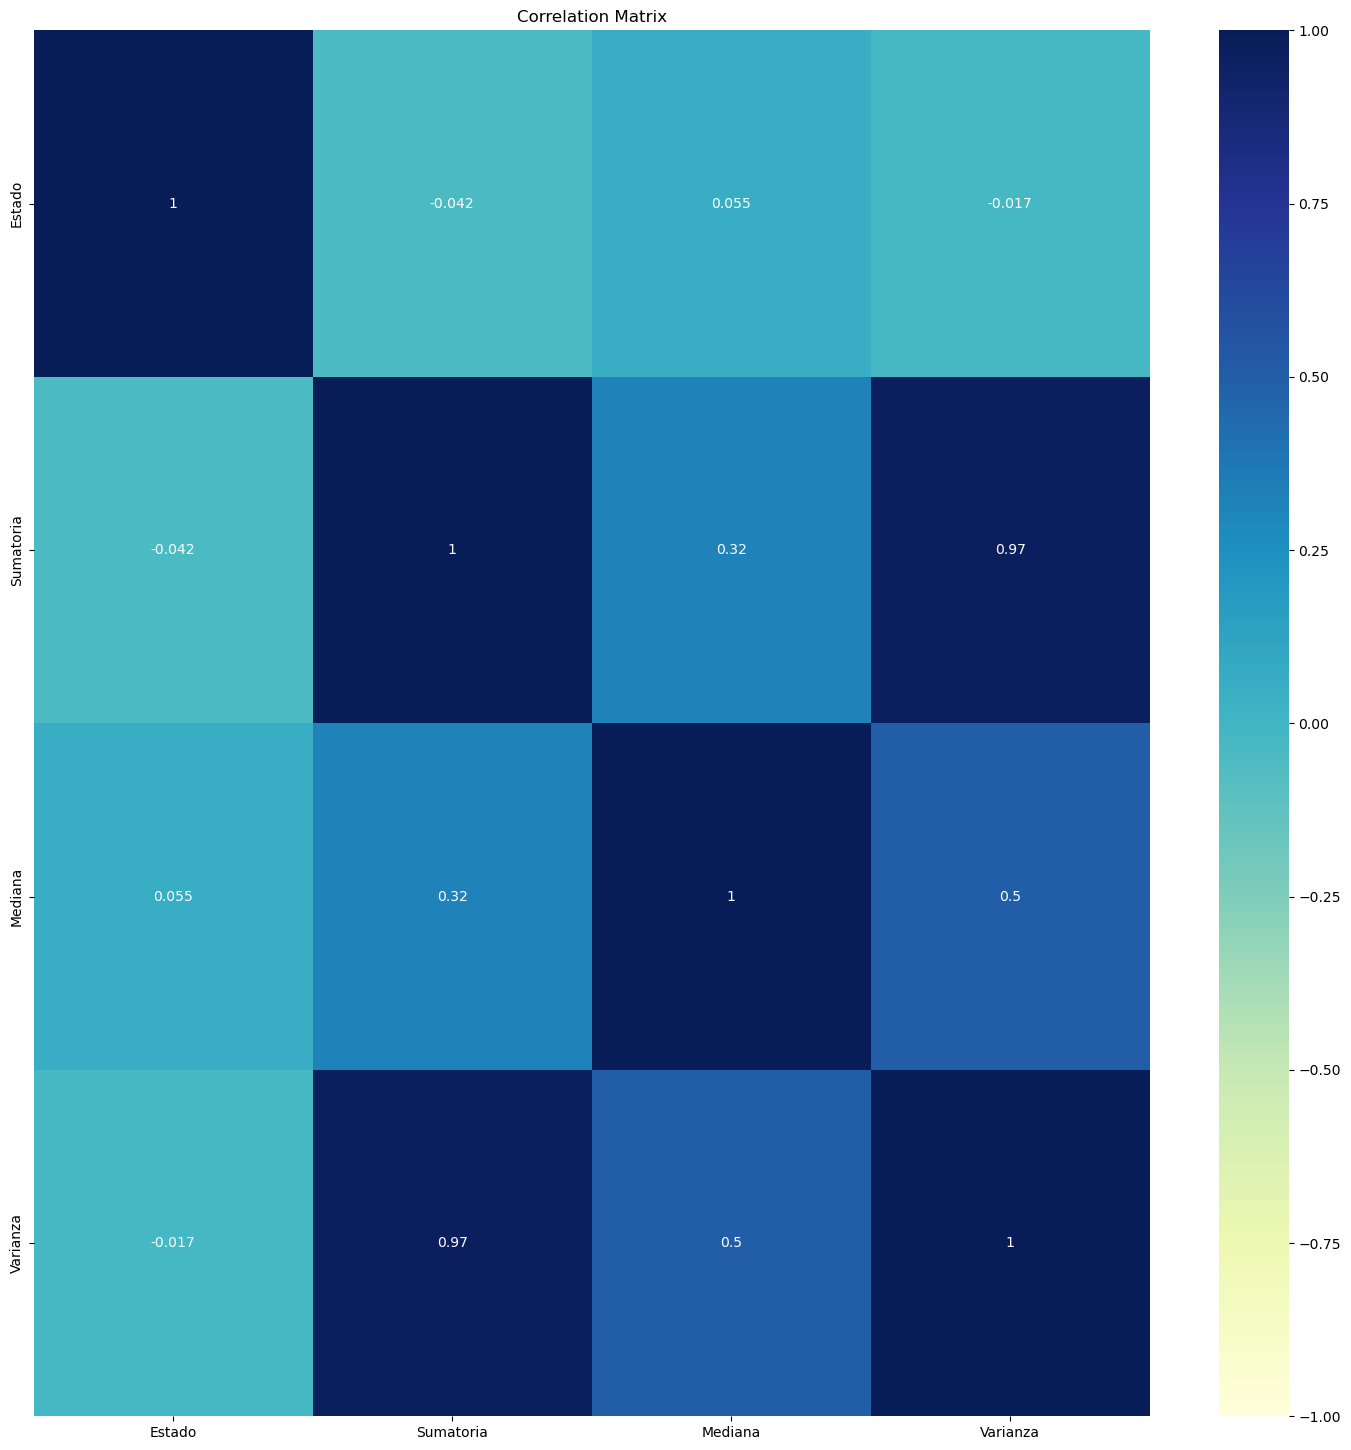

In [21]:
corr_matrix = d2.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [23]:
target_corr_df = pd.DataFrame(corr_matrix["Estado"].sort_values(ascending=False))
target_corr_df 

,Estado
Estado,1.000000
Mediana,0.054825
Varianza,-0.016609
Sumatoria,-0.042180


En este caso podemos observar que el estado va relacionado mayormente con la mediana que en el caso de la varianza o la suma, con esto en mente priorizaremos este parámetro para la generación de las redes neuronales

# 1. Ciclos normales y ciclos crepitantes

## Entrenamiento

In [140]:
con=(d2.Estado.values==1)|(d2.Estado.values==0)
x=d2.Varianza.values[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
Xtv=Xtv.reshape(-1, 1)
Xts=Xts.reshape(-1, 1)

print (Xtv.shape, Xts.shape)

(4264,) (4264,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2984, 1) (1280, 1)


In [152]:
ytv

array([0, 0, 1, ..., 1, 1, 1])

In [77]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [156]:
def me_da_pereza(a,Xtv,ytv,Xts,yts,target_names):
    a.fit(Xtv,ytv)
    predict_train = a.predict(Xtv)
    predict_test = a.predict(Xts)
    print("Train")
    print("------------")
    print(classification_report(ytv,predict_train))
    mc_train = confusion_matrix(ytv,predict_train)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train')
    print("------------")
    print("Test")
    print(classification_report(yts,predict_test))
    mc_train = confusion_matrix(yts,predict_test)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test')

En este caso vamos a probar con varias redes neuronales, cambiaremos la activación para cambiar la arquitectura lo mismo que el solucionador de ser necesario

In [160]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(2,2,2), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(2,2,2), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(2,2,2), activation='tanh', solver='adam', max_iter=10000)

# Relu

Train
------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1121
           1       0.62      1.00      0.77      1863

    accuracy                           0.62      2984
   macro avg       0.31      0.50      0.38      2984
weighted avg       0.39      0.62      0.48      2984

Confusion matrix, without normalization
[[   0 1121]
 [   0 1863]]
------------
Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       510
           1       0.60      1.00      0.75       770

    accuracy                           0.60      1280
   macro avg       0.30      0.50      0.38      1280
weighted avg       0.36      0.60      0.45      1280

Confusion matrix, without normalization
[[  0 510]
 [  0 770]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

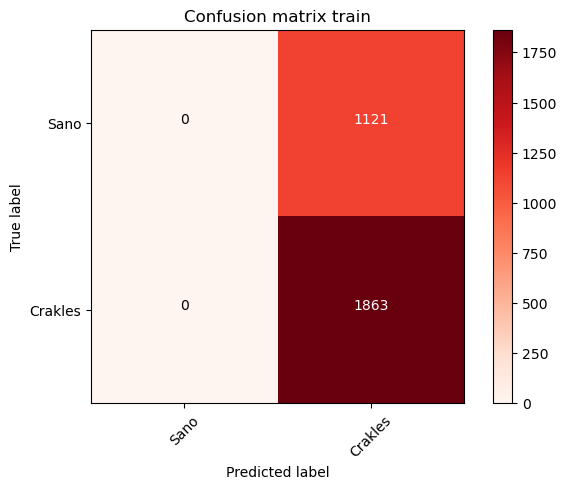

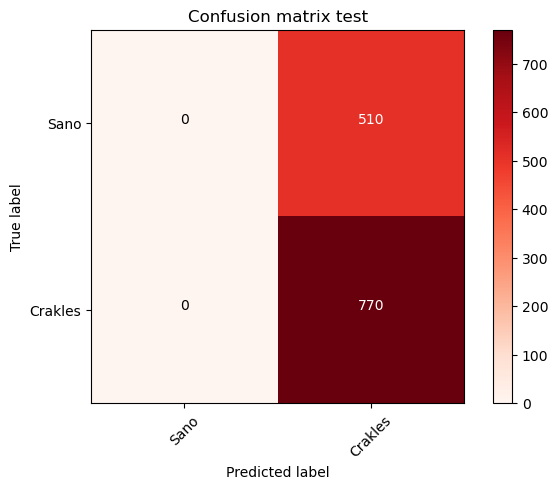

In [161]:
me_da_pereza(mlp_relu,Xtv,ytv,Xts,yts,['Sano','Crakles'])

Train
------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1121
           1       0.62      1.00      0.77      1863

    accuracy                           0.62      2984
   macro avg       0.31      0.50      0.38      2984
weighted avg       0.39      0.62      0.48      2984

Confusion matrix, without normalization
[[   0 1121]
 [   0 1863]]
------------
Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       510
           1       0.60      1.00      0.75       770

    accuracy                           0.60      1280
   macro avg       0.30      0.50      0.38      1280
weighted avg       0.36      0.60      0.45      1280

Confusion matrix, without normalization
[[  0 510]
 [  0 770]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

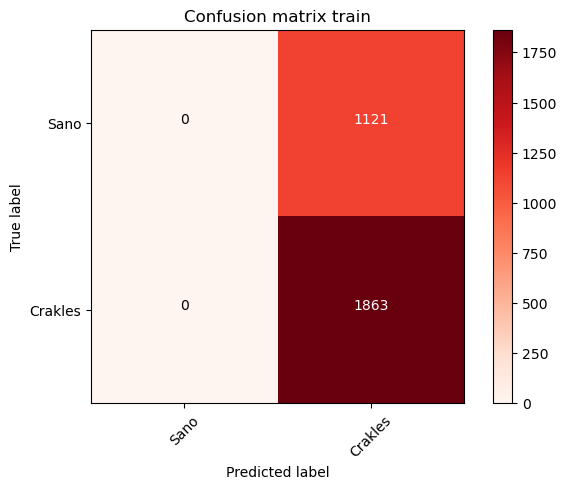

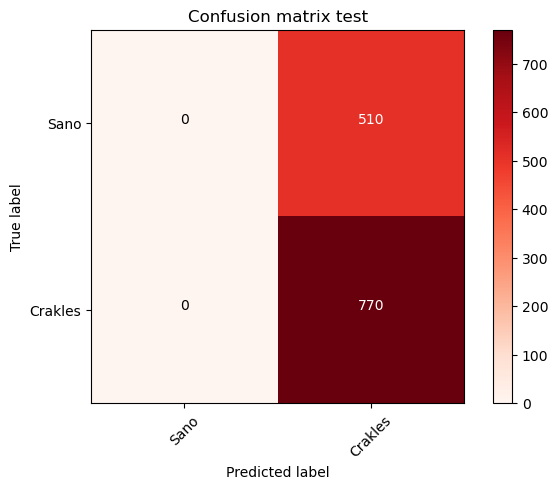

In [162]:
me_da_pereza(mlp_identity,Xtv,ytv,Xts,yts,['Sano','Crakles'])

Train
------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1121
           1       0.62      1.00      0.77      1863

    accuracy                           0.62      2984
   macro avg       0.31      0.50      0.38      2984
weighted avg       0.39      0.62      0.48      2984

Confusion matrix, without normalization
[[   0 1121]
 [   0 1863]]
------------
Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       510
           1       0.60      1.00      0.75       770

    accuracy                           0.60      1280
   macro avg       0.30      0.50      0.38      1280
weighted avg       0.36      0.60      0.45      1280

Confusion matrix, without normalization
[[  0 510]
 [  0 770]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

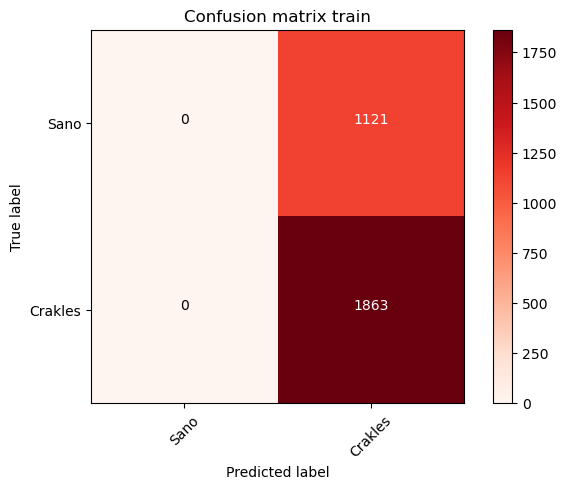

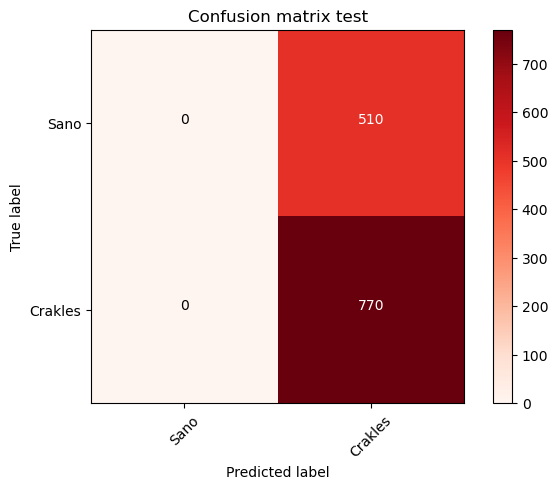

In [163]:
me_da_pereza(mlp_tanh,Xtv,ytv,Xts,yts,['Sano','Crakles'])

In [170]:
from sklearn import svm

clf = svm.NuSVC(gamma='auto')
clf.fit(Xtv,ytv)

predict_train = clf.predict(Xtv)
predict_test = clf.predict(Xts)

target_names = ['Sano','Crakles']
print(classification_report(ytv,predict_train,target_names=target_names))

print(classification_report(yts,predict_test,target_names=target_names))

              precision    recall  f1-score   support

        Sano       0.38      0.99      0.55      1121
     Crakles       0.69      0.01      0.03      1863

    accuracy                           0.38      2984
   macro avg       0.53      0.50      0.29      2984
weighted avg       0.57      0.38      0.22      2984

              precision    recall  f1-score   support

        Sano       0.40      0.99      0.57       510
     Crakles       0.78      0.02      0.04       770

    accuracy                           0.41      1280
   macro avg       0.59      0.51      0.30      1280
weighted avg       0.63      0.41      0.25      1280

